In [1]:
import ffi
from model import *
from halfkp import *
import os

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# from tqdm.notebook import tqdm, trange
from tqdm.auto import tqdm, trange

In [4]:
class EMA:
    def __init__(self, initial=None, k=0.1):
        self.value = initial
        self.k = k

    def update(self, x):
        if self.value is None:
            self.value = x
        else:
            self.value = (1 - self.k) * self.value + self.k * x

In [5]:
ffi.load_module('../build/Release/satpymod.dll')

In [6]:
batch_size = 16*1024
device = torch.device('cuda')
n_prefetch = 4
n_workers = 4
n_virtual = True

experiment_name = 'd6nnv4_virtual_scratch'
weight_folder = experiment_name
os.makedirs(weight_folder, exist_ok=True)

In [7]:
stream = ffi.BatchStream('data/d6nnv4.bin', 'data/d6nnv4.index', 
                         n_prefetch, n_workers, batch_size, n_virtual)

In [8]:
model = Model(N_FT + N_VIRT_FT*True).to(device)

In [10]:
# model.load_state_dict(torch.load('d8nn_virtual_scratch/net_90.pt'))

<All keys matched successfully>

In [11]:
# model.coalesce_transformer()

In [9]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [10]:
ema_loss = EMA()
losses = []
ema_losses = []

In [11]:
def lerp(t, a, b):
    return (1 - t) * a + t * b

In [12]:
def get_lr(t, max_t, min_lr, max_lr):
    return min_lr + 0.5 * (max_lr-min_lr) * (1 + np.cos(t/max_t * np.pi))

In [ ]:
total = 0
n_epochs = 80
min_lr, max_lr = 1e-5, 8e-4
mean_loss = 0
do_warmup = True
for epoch in (te := trange(10, n_epochs)):
#     lambda_ = lerp(epoch/n_epochs, 1.0, 0.75)
    lambda_ = 1.0
    lr = get_lr(epoch, n_epochs, min_lr, max_lr)
    t = tqdm(total=total if epoch else None)
    k = 0
    
    for g in opt.param_groups:
        g['lr'] = lr
    
    while True:
        if do_warmup:
            warmup_lr = lerp(k/7000, 0, lr)
            for g in opt.param_groups:
                g['lr'] = warmup_lr
        
        batch = stream.next_batch()
        if batch is None:
            t.close()
            break
        wft_ics, wft_vals, bft_ics, bft_vals, stm, score, result = batch.to_torch(device)

        pred = model(wft_ics, wft_vals, bft_ics, bft_vals, stm)
        loss = compute_loss(pred, score, result, lambda_)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        model._clip_weights()
        losses.append(loss.item())
        ema_loss.update(loss.item())
        ema_losses.append(ema_loss.value)

        t.set_description(f'epoch {epoch} BL {ema_loss.value:.6f} EL {mean_loss:.6f} L {lambda_:.2f}')
        t.update()
        k += 1
    mean_loss = np.mean(losses[-k:])
    te.set_description(f'epoch {epoch} mean_loss {mean_loss:.6f} lr {lr:.2e} L {lambda_:.2f}')
    total = k
    do_warmup = False
    
    if epoch % 10 == 0 or epoch + 1 == n_epochs:
        torch.save(model.state_dict(), f'{weight_folder}/net_{epoch}.pt')

  0%|          | 0/70 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3926 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/7076 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/7076 [00:00<?, ?it/s]

  0%|          | 0/7076 [00:00<?, ?it/s]

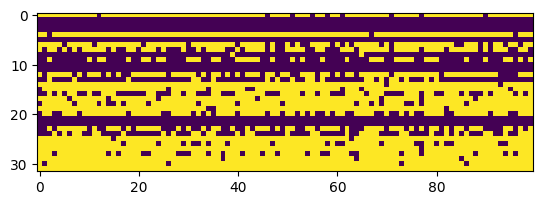

In [17]:
plt.imshow(torch.abs(model.fc1.weight.grad.cpu()[:, :100]) > 1e-6)

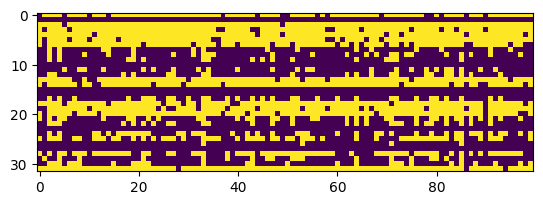

In [16]:
plt.imshow(torch.abs(model.fc1.weight.grad.cpu()[:, :100]) > 1e-6)

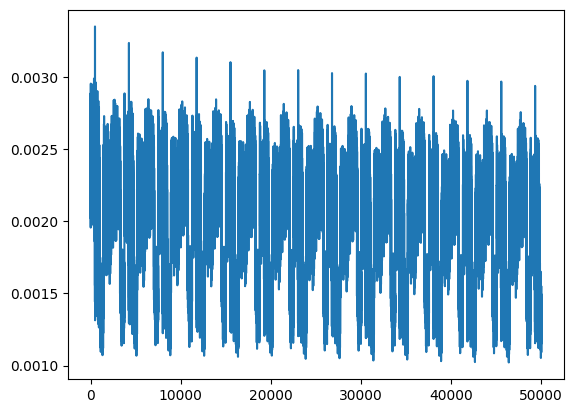

In [18]:
plt.plot(np.arange(len(losses)), losses)

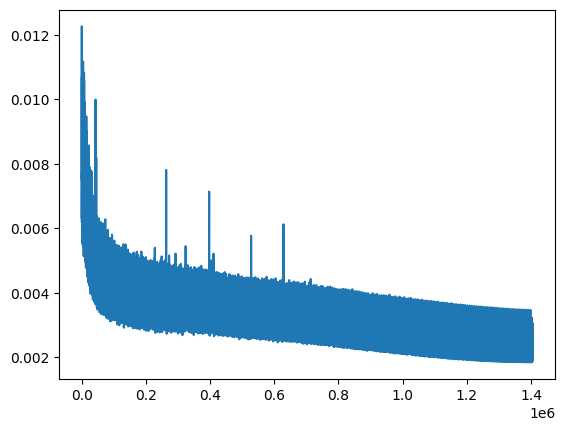

In [18]:
plt.plot(np.arange(len(losses)), losses)

In [19]:
with torch.no_grad():
    y = pred * S_O

In [20]:
y[:100].view(-1).long()

tensor([ -62,   24,    0,   29,    5,   17,  -20,   68,  -70,   70,  -71,   69,
         -72,   63,  -63,   64,  -62,   48,  -58,   61,  -50,   70,  -67,   76,
         -39,   75,   54,  -87,   89,  -96,   81,  -92,  110,   44,  142, -125,
          88,  155, -173,  214,  -95, -264,  294, -293,  402, -333,  -17,   16,
         -17,   15,  -17,   17,  -18,   17,  -23,   26,  -30,   24,  -14,   15,
         -12,   19,  -15,    7,   44,  -28,    3,   58,  -20,   63,  -17,   -8,
         -22,    5,   -6,   20,  -49,   57,  -37,  -23,   23,  -72,   97, -106,
          96, -169,  225,  -76,   39,  -66,   67,  -59,  104,  -86,  111,  -65,
          69,  118,  -72,  133], device='cuda:0')

In [21]:
score[:100].view(-1).long()

tensor([ -63,   69,  -56,   73,    9,   27,  -13,  105,  -72,   64,  -64,   64,
         -64,   70,  -70,   70,  -56,   64,  -50,   50,  -52,   52,  -83,   83,
         -83,   83,   98,  -89,  112,  -86,  102, -131,  131,  159,  141, -142,
         142,  217, -216,  232, -234, -243,  302, -307,  349, -322,  -22,   19,
         -19,   19,  -19,   14,  -16,   17,  -16,   26,  -32,   17,  -14,   13,
         -16,   32,  -35,   52,   44,  -27,   23,   -5,   53,  274,  -18,   23,
         -58,   57,  -47,   47,  -41,   70,   51,  -68,   60,  -71,   77,  -77,
          79,  -95,  104,  -98,   98,  -91,   96,  -94,   97,  -94,  112, -105,
          96,  129, -104,  115], device='cuda:0')

In [22]:
import chess

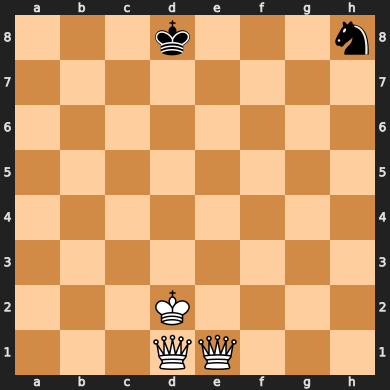

In [23]:
board = chess.Board('3k3n/8/8/8/8/8/3K4/3QQ3 w - - 0 1')
# board = chess.Board('8/2pb1pp1/Q1nk4/1p4B1/3P4/5P2/P1P1K1P1/5B1q w - - 0 1')
board

In [24]:
model.evaluate_board(board)

tensor([[1054.4973]], device='cuda:0')

In [25]:
score[:256].view(-1).long()

tensor([ -173,   183,   -95,   197,   134,  -121,   254,  -240,  -268,  -266,
          285,  -111,   111,  -111,   232,  -141,   325,  -213,   272,   227,
          272,  -271,   317,  -301,   330,  -219,   279,  -274,   330,  -219,
          279,  -263,   310,  -187,  -146,   176,   -50,   225,    81,   -68,
          148,   -70,  -114,   184,  -186,   383,   512,   781,   800,   846,
         -833,   964,  -900,   967,  -927,  1104, -1101,  1198,  -969,  1177,
        -1205,  1231, -1272,  1354, -1322, -1326,  1406, -1330,  1411, -1376,
         1376, -1331,  1357, -1335,  1394, -1367,  1380, -1318,  1411, -1306,
         1350, -1263,  1367, -1355,  1392, -1305,  1385, -1377, -1451,  1545,
         1495,  1495,  1495,  1495,  1473,  1473,  1473,  1473, -1377,  1423,
        -1377,  1434,  1434,  1423,  1423, -1365,  1376, -1283,  1357,  1330,
         1322, -1304,  1357, -1349,  1394,  1359,  1359,  1402,  1359,  1359,
         1359,  1402, -1361,  1398, -1377,  1388,  1485, -1448, 

In [23]:
result[:256].view(-1)

tensor([0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 

In [24]:
stm[:256].view(-1)

tensor([1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 

In [14]:
losses = []
while True:
    batch = stream.next_batch()
    if batch is None:
        break
    wft_ics, wft_vals, bft_ics, bft_vals, stm, score, result = batch.to_torch(device)

    pred = model(wft_ics, wft_vals, bft_ics, bft_vals, stm)
    loss = compute_loss(pred, score, result, 1.0)
    losses.append(loss.item())

In [15]:
np.mean(losses)

0.0026031575398519635